Markdown box to explain premise.
- Brief description of how the ising model works
- we can look at: how coupling strength and background temperature affect final state, magnetization, and energy levels.
- Will consider different lattices--e.g. square, triangular, and hexagonal
- Will look at animation of how the states evolve over time

Probably good to insert a markdown over here with an explanation of how this relates to phase transition and what that means physically

In [16]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
import numba
from numba import njit
from numpy.random import randint


# NUMBA-OPTIMIZED FUNCTIONS
@njit("Tuple((f8[:], f8[:], i8[:, :]))(i8, i8[:,:], i8, f8, i8)", nogil=True)
def _metropolis_basic_numba(N, spin_arr, times, BJ, E):
    """Numba-optimized basic Metropolis (zero external field)"""
    spin_arr_copy = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)

    for t in range(0, times-1):
        x = randint(0, N)
        y = np.random.randint(0, N)
        spin_i = spin_arr_copy[x, y]
        spin_f = -spin_i

        neighbors = [(x-1, y), ((x+1)%N, y), (x, y-1), (x, (y+1)%N)]
        E_i = sum([-spin_i * spin_arr_copy[nx, ny] for nx, ny in neighbors])
        E_f = sum([-spin_f * spin_arr_copy[nx, ny] for nx, ny in neighbors])

        dE = E_f - E_i
        if dE > 0 and np.random.random() < np.exp(-BJ * dE):
            spin_arr_copy[x, y] = spin_f
            E += dE
        elif dE <= 0:
            spin_arr_copy[x, y] = spin_f
            E += dE

        net_spins[t] = spin_arr_copy.sum()
        net_energy[t] = E

    return net_spins, net_energy, spin_arr_copy


# EXTERNAL FIELD CLASSES

class ExternalField:
    """Base class for external fields"""

    def time_dependent(self, t):
        """Time-dependent component H(t)"""
        return 0.0

    def position_dependent(self, size):
        """Position-dependent component H[i,j]"""
        return np.zeros((size, size))


class ZeroField(ExternalField):
    """No external field"""
    pass


class UTField(ExternalField):
    """UT-shaped position-dependent field"""

    def __init__(self, H0=2.0):
        self.H0 = H0

    def position_dependent(self, size):
        """Create UT-shaped field pattern"""
        H = np.zeros((size, size), dtype=float)

        t = max(1, size // 25)
        top = size // 5
        bottom = 4 * size // 5

        # U letter
        u_left = size // 10
        u_right = size // 3
        H[top:bottom, u_left:u_left + t] = self.H0
        H[top:bottom, u_right - t:u_right] = self.H0
        H[bottom - t:bottom, u_left:u_right] = self.H0

        # T letter
        t_left = size // 2
        t_right = 9 * size // 10
        H[top:top + t, t_left:t_right] = self.H0
        t_center = (t_left + t_right) // 2
        H[top:bottom, t_center - t // 2 : t_center + (t + 1) // 2] = self.H0

        return H


class OscillatingField(ExternalField):
    """Time-dependent oscillating field"""

    def __init__(self, amplitude=10.0, omega=0.00005):
        self.amplitude = amplitude
        self.omega = omega

    def time_dependent(self, t):
        """Cosine oscillation"""
        return self.amplitude * np.cos(np.pi * self.omega * t)


class ConstantField(ExternalField):
    """Constant external field"""

    def __init__(self, strength=1.0):
        self.strength = strength

    def time_dependent(self, t):
        return self.strength

# MAIN ISING MODEL CLASS

class IsingModel:
    """
    2D Ising Model with external fields

    Parameters
    ----------
    N : int
        Lattice size (N x N)
    temperature : float
        Temperature in units of J/k
    external_field : ExternalField, optional
        External field object
    """

    def __init__(self, N, temperature=1.0, external_field=None):
        self.N = N
        self.temperature = temperature
        self.BJ = 1.0 / temperature
        self.lattice = None
        self.external_field = external_field or ZeroField()

        # Cache position-dependent field
        self._H_pos = self.external_field.position_dependent(N)

        # History tracking
        self.spins_history = None
        self.energy_history = None
        self.snapshots = None
        self.snapshot_times = None

    def initialize_lattice(self, threshold=0.5):
        """
        Initialize lattice with random spins

        Parameters
        ----------
        threshold : float
            Fraction of spin-up sites (0.5 = random, 1.0 = all up, 0.0 = all down)
        """
        init_random = np.random.random((self.N, self.N))
        self.lattice = np.where(init_random >= threshold, 1, -1)
        return self.lattice

    def calculate_energy(self, lattice=None):
        """
        Calculate total energy from nearest-neighbor interactions
        Uses convolution with periodic boundary conditions
        """
        if lattice is None:
            lattice = self.lattice

        kernel = generate_binary_structure(2, 1)
        kernel[1][1] = False
        total = -lattice * convolve(lattice, kernel, mode='wrap', cval=0)
        return total.sum()

    def metropolis_basic(self, timesteps):
        """
        Run Metropolis algorithm without external field (uses Numba optimization)

        Parameters
        ----------
        timesteps : int
            Number of Monte Carlo steps

        Returns
        -------
        tuple
            (spins_history, energy_history, final_lattice)
        """
        if self.lattice is None:
            self.initialize_lattice()

        E = self.calculate_energy()
        spins, energies, final = _metropolis_basic_numba(
            self.N, self.lattice, timesteps, self.BJ, E
        )

        self.spins_history = spins
        self.energy_history = energies
        self.lattice = final

        return spins, energies, final

    def metropolis_with_field(self, timesteps):
        """
        Run Metropolis algorithm with external field

        Parameters
        ----------
        timesteps : int
            Number of Monte Carlo steps

        Returns
        -------
        tuple
            (spins_history, energy_history, final_lattice)
        """
        if self.lattice is None:
            self.initialize_lattice()

        spin_arr_copy = self.lattice.copy()
        E = self.calculate_energy()
        net_spins = np.zeros(timesteps - 1)
        net_energy = np.zeros(timesteps - 1)

        for t in range(0, timesteps - 1):
            # Pick random spin
            x = randint(0, self.N)
            y = np.random.randint(0, self.N)
            spin_i = spin_arr_copy[x, y]
            spin_f = -spin_i

            # Compute energy change from neighbors
            neighbors = [(x - 1, y), ((x + 1) % self.N, y),
                        (x, y - 1), (x, (y + 1) % self.N)]
            E_i = sum([-spin_i * spin_arr_copy[nx, ny] for nx, ny in neighbors])
            E_f = sum([-spin_f * spin_arr_copy[nx, ny] for nx, ny in neighbors])

            # Include field contributions
            dE = E_f - E_i
            H_t = self.external_field.time_dependent(t)
            deltaE = dE - H_t * (spin_f - spin_i) - self._H_pos[x, y] * (spin_f - spin_i)

            # Metropolis acceptance
            if deltaE > 0 and np.random.random() < np.exp(-self.BJ * deltaE):
                spin_arr_copy[x, y] = spin_f
                E += dE
            elif deltaE <= 0:
                spin_arr_copy[x, y] = spin_f
                E += dE

            # Total energy including fields
            E_tot = E - (H_t * np.sum(spin_arr_copy) + np.sum(self._H_pos * spin_arr_copy))
            net_spins[t] = spin_arr_copy.sum()
            net_energy[t] = E_tot

        self.spins_history = net_spins
        self.energy_history = net_energy
        self.lattice = spin_arr_copy

        return net_spins, net_energy, spin_arr_copy

    def metropolis_with_snapshots(self, timesteps, snapshot_interval=1000):
        """
        Run Metropolis with periodic snapshots for visualization

        Parameters
        ----------
        timesteps : int
            Number of Monte Carlo steps
        snapshot_interval : int
            Save snapshot every N steps

        Returns
        -------
        tuple
            (spins_history, energy_history, final_lattice, snapshots, snapshot_times)
        """
        if self.lattice is None:
            self.initialize_lattice()

        spin_arr_copy = self.lattice.copy()
        E = self.calculate_energy()
        net_spins = np.zeros(timesteps - 1)
        net_energy = np.zeros(timesteps - 1)

        # Store snapshots
        num_snapshots = timesteps // snapshot_interval
        snapshots = np.zeros((num_snapshots, self.N, self.N))
        snapshot_times = []
        snapshot_idx = 0

        for t in range(0, timesteps - 1):
            # Save snapshot at intervals
            if t % snapshot_interval == 0 and snapshot_idx < num_snapshots:
                snapshots[snapshot_idx] = spin_arr_copy.copy()
                snapshot_times.append(t)
                snapshot_idx += 1

            # Pick random spin
            x = randint(0, self.N)
            y = np.random.randint(0, self.N)
            spin_i = spin_arr_copy[x, y]
            spin_f = -spin_i

            # Compute energy change
            neighbors = [(x - 1, y), ((x + 1) % self.N, y),
                        (x, y - 1), (x, (y + 1) % self.N)]
            E_i = sum([-spin_i * spin_arr_copy[nx, ny] for nx, ny in neighbors])
            E_f = sum([-spin_f * spin_arr_copy[nx, ny] for nx, ny in neighbors])

            # Include field contributions
            dE = E_f - E_i
            H_t = self.external_field.time_dependent(t)
            deltaE = dE - H_t * (spin_f - spin_i) - self._H_pos[x, y] * (spin_f - spin_i)

            # Metropolis acceptance
            if deltaE > 0 and np.random.random() < np.exp(-self.BJ * deltaE):
                spin_arr_copy[x, y] = spin_f
                E += dE
            elif deltaE <= 0:
                spin_arr_copy[x, y] = spin_f
                E += dE

            # Total energy
            E_tot = E - (H_t * np.sum(spin_arr_copy) + np.sum(self._H_pos * spin_arr_copy))
            net_spins[t] = spin_arr_copy.sum()
            net_energy[t] = E_tot

        self.spins_history = net_spins
        self.energy_history = net_energy
        self.lattice = spin_arr_copy
        self.snapshots = snapshots
        self.snapshot_times = snapshot_times

        return net_spins, net_energy, spin_arr_copy, snapshots, snapshot_times

    def get_magnetization(self):
        """Get current magnetization per site"""
        if self.lattice is None:
            return None
        return self.lattice.sum() / self.N**2

    def set_temperature(self, temperature):
        """Update temperature"""
        self.temperature = temperature
        self.BJ = 1.0 / temperature


#DATA ANALYSIS CLASSES
class IsingAnalysis:
    """Analysis tools for Ising model"""

    @staticmethod
    def theoretical_magnetization(T, J=1.0, k=1.0):
        """
        Exact 2D Ising magnetization (Onsager/Yang result)
        Valid for T < Tc, zero for T > Tc
        """
        Tc = 2.269185 * J / k
        if T > Tc:
            return 0.0
        else:
            z = np.exp(-2 * J / (k * T))
            return (1 + z**2)**0.25 * (1 - 6 * z**2 + z**4)**0.125

    @staticmethod
    def phase_transition_scan(N, temperatures, timesteps=100000, threshold=0.5):
        """
        Scan magnetization vs temperature

        Parameters
        ----------
        N : int
            Lattice size
        temperatures : array
            Array of temperatures to scan
        timesteps : int
            MC steps per temperature
        threshold : float
            Initial lattice threshold

        Returns
        -------
        dict
            Results containing magnetizations, energies, and statistics
        """
        BJs = 1.0 / temperatures
        ms = np.zeros(len(BJs))
        E_means = np.zeros(len(BJs))
        E_stds = np.zeros(len(BJs))

        model = IsingModel(N, temperature=temperatures[0])
        model.initialize_lattice(threshold=threshold)

        for i, (T, bj) in enumerate(zip(temperatures, BJs)):
            model.set_temperature(T)
            spins, energies, _ = model.metropolis_basic(timesteps)

            # Discard first half for equilibration
            ms[i] = spins[-timesteps//2:].mean() / N**2
            E_means[i] = energies[-timesteps//2:].mean()
            E_stds[i] = energies[-timesteps//2:].std()

            print(f"T = {T:.3f}, <m> = {ms[i]:.4f}")

        return {
            'magnetizations': ms,
            'energy_means': E_means,
            'energy_stds': E_stds,
            'temperatures': temperatures
        }

class IsingVisualizer:
    """Visualization tools for Ising model"""

    @staticmethod
    def plot_lattice(lattice, title="Spin Configuration"):
        """Display lattice configuration"""
        plt.figure(figsize=(8, 8))
        plt.imshow(lattice, cmap='gray', vmin=-1, vmax=1)
        plt.title(title, fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.colorbar(label='Spin', shrink=0.8)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_field(field, title="External Field"):
        """Display external field configuration"""
        plt.figure(figsize=(8, 8))
        plt.imshow(field, cmap='Oranges')
        plt.title(title, fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.colorbar(label='Field Strength', shrink=0.8)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_evolution(N, spins, energies, temperature):
        """Plot magnetization and energy evolution"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        axes[0].plot(spins / N**2, linewidth=0.8)
        axes[0].set_xlabel('Monte Carlo Steps', fontsize=11)
        axes[0].set_ylabel(r'Average Spin $\langle m \rangle$', fontsize=11)
        axes[0].grid(alpha=0.3)

        axes[1].plot(energies, linewidth=0.8)
        axes[1].set_xlabel('Monte Carlo Steps', fontsize=11)
        axes[1].set_ylabel(r'Energy $E/J$', fontsize=11)
        axes[1].grid(alpha=0.3)

        fig.tight_layout()
        fig.suptitle(f'Evolution at T = {temperature:.3f}',
                     y=1.02, size=14, fontweight='bold')
        plt.show()

    @staticmethod
    def plot_phase_transition(results, N):
        """Plot phase transition with theoretical curve"""
        temps = results['temperatures']
        ms = results['magnetizations']

        # Theoretical curve
        theory_mag = np.array([
            abs(IsingAnalysis.theoretical_magnetization(T))
            for T in temps
        ])

        plt.figure(figsize=(10, 6))
        plt.plot(temps, np.abs(ms), 'o-', markersize=4, linewidth=2,
                 label=f'MC Simulation (N={N})')
        plt.plot(temps, theory_mag, '-', linewidth=2.5,
                 label='Theoretical (Onsager)', color='red', alpha=0.7)
        plt.axvline(2.269185, color='k', linestyle='--', linewidth=1.5,
                    label=r'$T_c = 2.269$')

        plt.xlabel('Temperature T (J/k)', fontsize=12)
        plt.ylabel('Magnetization |m|', fontsize=12)
        plt.title('2D Ising Model: Phase Transition', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(alpha=0.3)
        plt.xlim(temps[-1], temps[0])
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_snapshots(snapshots, snapshot_times, title="Lattice Evolution"):
        """Plot grid of snapshots"""
        num_to_show = min(9, len(snapshots))
        indices = np.linspace(0, len(snapshots) - 1, num_to_show, dtype=int)

        fig, axes = plt.subplots(3, 3, figsize=(16, 12))
        axes = axes.flatten()

        for i, idx in enumerate(indices):
            axes[i].imshow(snapshots[idx], cmap='gray', vmin=-1, vmax=1)
            axes[i].set_title(f'Step {snapshot_times[idx]:,}',
                            fontsize=10, fontweight='bold')
            axes[i].axis('off')

        for j in range(num_to_show, len(axes)):
            axes[j].axis('off')

        plt.suptitle(title, fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()


Simulating phase transition...
Lattice size: 30 × 30
Temperature range: 10.00 to 0.51
Critical temperature: Tc ≈ 2.269

T = 10.000, <m> = 0.0087
T = 8.333, <m> = 0.0099
T = 7.143, <m> = 0.0049
T = 6.250, <m> = 0.0093
T = 5.556, <m> = 0.0031
T = 5.000, <m> = -0.0182
T = 4.545, <m> = -0.0221
T = 4.167, <m> = 0.0249
T = 3.846, <m> = -0.0127
T = 3.571, <m> = 0.0117
T = 3.333, <m> = -0.0203
T = 3.125, <m> = 0.1078
T = 2.941, <m> = 0.0968
T = 2.778, <m> = -0.1228
T = 2.632, <m> = -0.0233
T = 2.500, <m> = 0.2063
T = 2.381, <m> = 0.5188
T = 2.273, <m> = 0.6412
T = 2.174, <m> = 0.8486
T = 2.083, <m> = 0.9101
T = 2.000, <m> = 0.9122
T = 1.923, <m> = 0.9374
T = 1.852, <m> = 0.9439
T = 1.786, <m> = 0.9549
T = 1.724, <m> = 0.9680
T = 1.667, <m> = 0.9753
T = 1.613, <m> = 0.9821
T = 1.562, <m> = 0.9831
T = 1.515, <m> = 0.9846
T = 1.471, <m> = 0.9886
T = 1.429, <m> = 0.9900
T = 1.389, <m> = 0.9927
T = 1.351, <m> = 0.9913
T = 1.316, <m> = 0.9936
T = 1.282, <m> = 0.9940
T = 1.250, <m> = 0.9966
T = 1.220

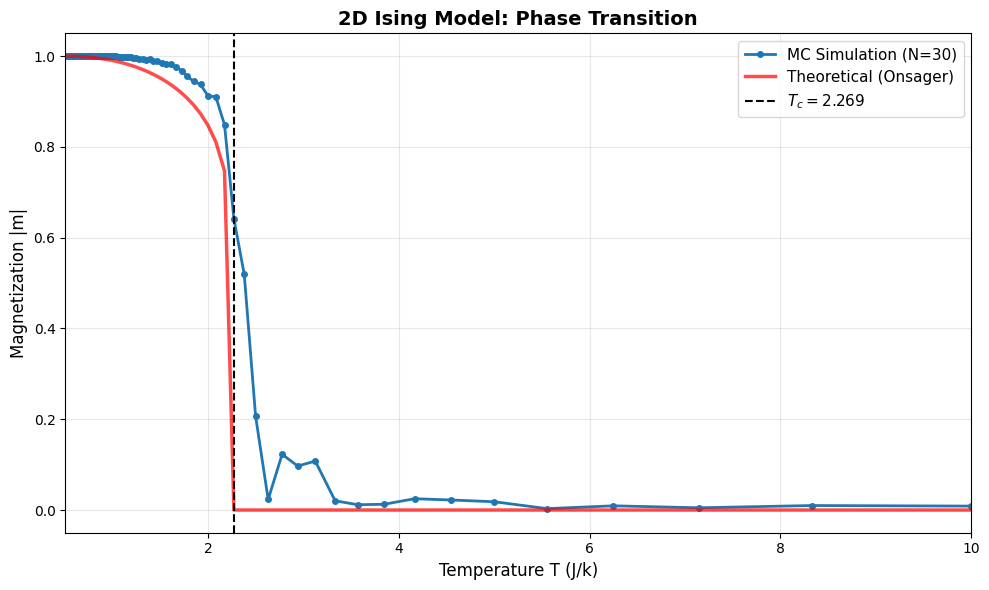

In [17]:

# PHASE TRANSITION ANALYSIS

N = 30
BJs = np.arange(0.1, 2.0, 0.02)
temperatures = 1 / BJs

print(f"Simulating phase transition...")
print(f"Lattice size: {N} × {N}")
print(f"Temperature range: {temperatures[0]:.2f} to {temperatures[-1]:.2f}")
print(f"Critical temperature: Tc ≈ 2.269")
print()

# Run phase transition scan
results = IsingAnalysis.phase_transition_scan(
    N=N,
    temperatures=temperatures,
    timesteps=100000,
    threshold=1  # Start from all spin-up
)

# Plot phase transition
vis = IsingVisualizer()
vis.plot_phase_transition(results, N)


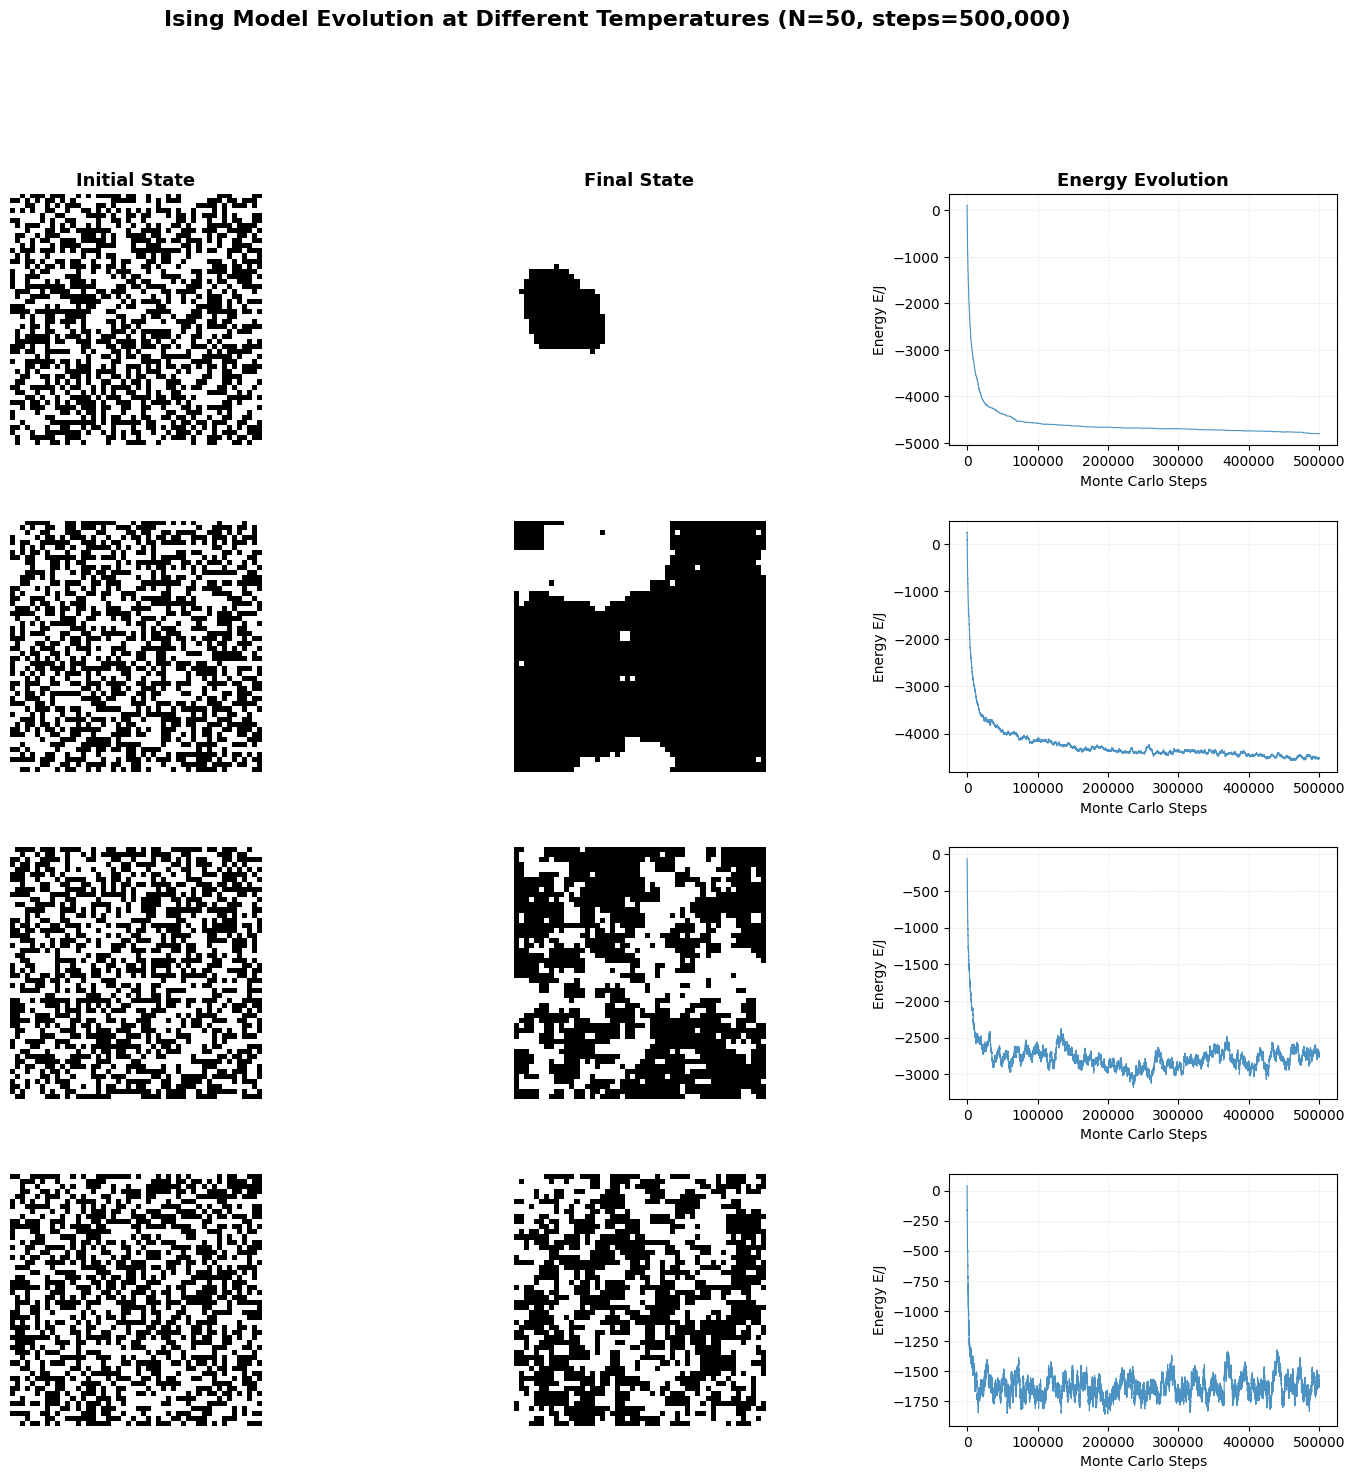

In [18]:
# LATTICE EVOLUTION: INITIAL/FINAL STATES AND ENERGY AT DIFFERENT TEMPS
test_temps = [0.5, 1.5, 2.5, 3.5]
timesteps = 500000
N = 50
fig = plt.figure(figsize=(18, 16))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

for idx, T in enumerate(test_temps):

    model = IsingModel(N=N, temperature=T)
    initial_state = model.initialize_lattice(threshold=0.5).copy()

    spins, energies, final = model.metropolis_basic(timesteps)

    ax_initial = fig.add_subplot(gs[idx, 0])
    ax_initial.imshow(initial_state, cmap='gray', vmin=-1, vmax=1)
    if idx == 0:
        ax_initial.set_title('Initial State', fontsize=13, fontweight='bold')
    ax_initial.set_ylabel(f'T = {T:.2f}' + (r' (< $T_c$)' if T < 2.27 else r' (> $T_c$)'),
                         fontsize=12, fontweight='bold')
    ax_initial.axis('off')

    ax_final = fig.add_subplot(gs[idx, 1])
    ax_final.imshow(final, cmap='gray', vmin=-1, vmax=1)
    if idx == 0:
        ax_final.set_title('Final State', fontsize=13, fontweight='bold')
    ax_final.axis('off')

    # Plot energy evolution (column 2)
    ax_energy = fig.add_subplot(gs[idx, 2])
    ax_energy.plot(energies, linewidth=0.8, color='tab:blue', alpha=0.8)
    ax_energy.set_xlabel('Monte Carlo Steps', fontsize=10)
    ax_energy.set_ylabel('Energy E/J', fontsize=10)
    ax_energy.grid(alpha=0.3, linestyle='--', linewidth=0.5)
    if idx == 0:
        ax_energy.set_title('Energy Evolution', fontsize=13, fontweight='bold')

plt.suptitle(f'Ising Model Evolution at Different Temperatures (N={N}, steps={timesteps:,})',
             fontsize=16, fontweight='bold', y=0.995)
plt.show()


Lattice size: 100 × 100
Field strength: H0 = 5



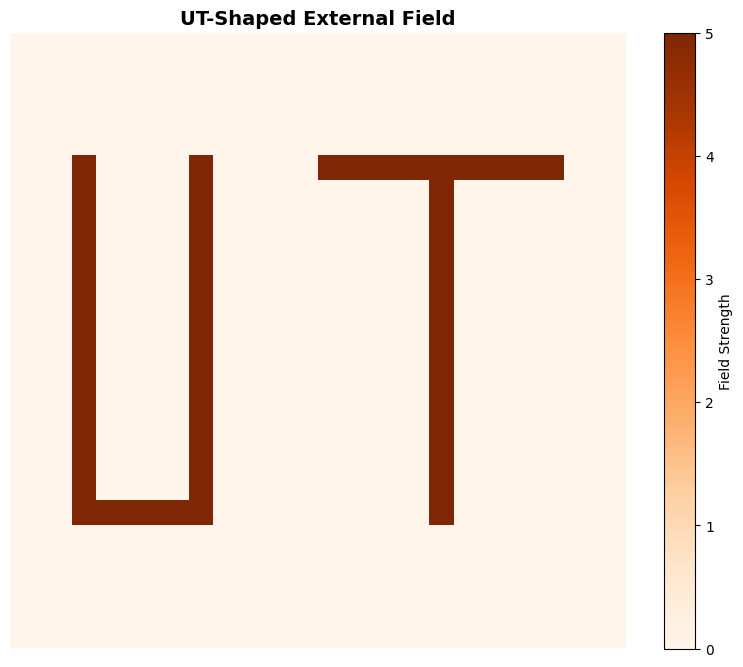

Captured 10 snapshots


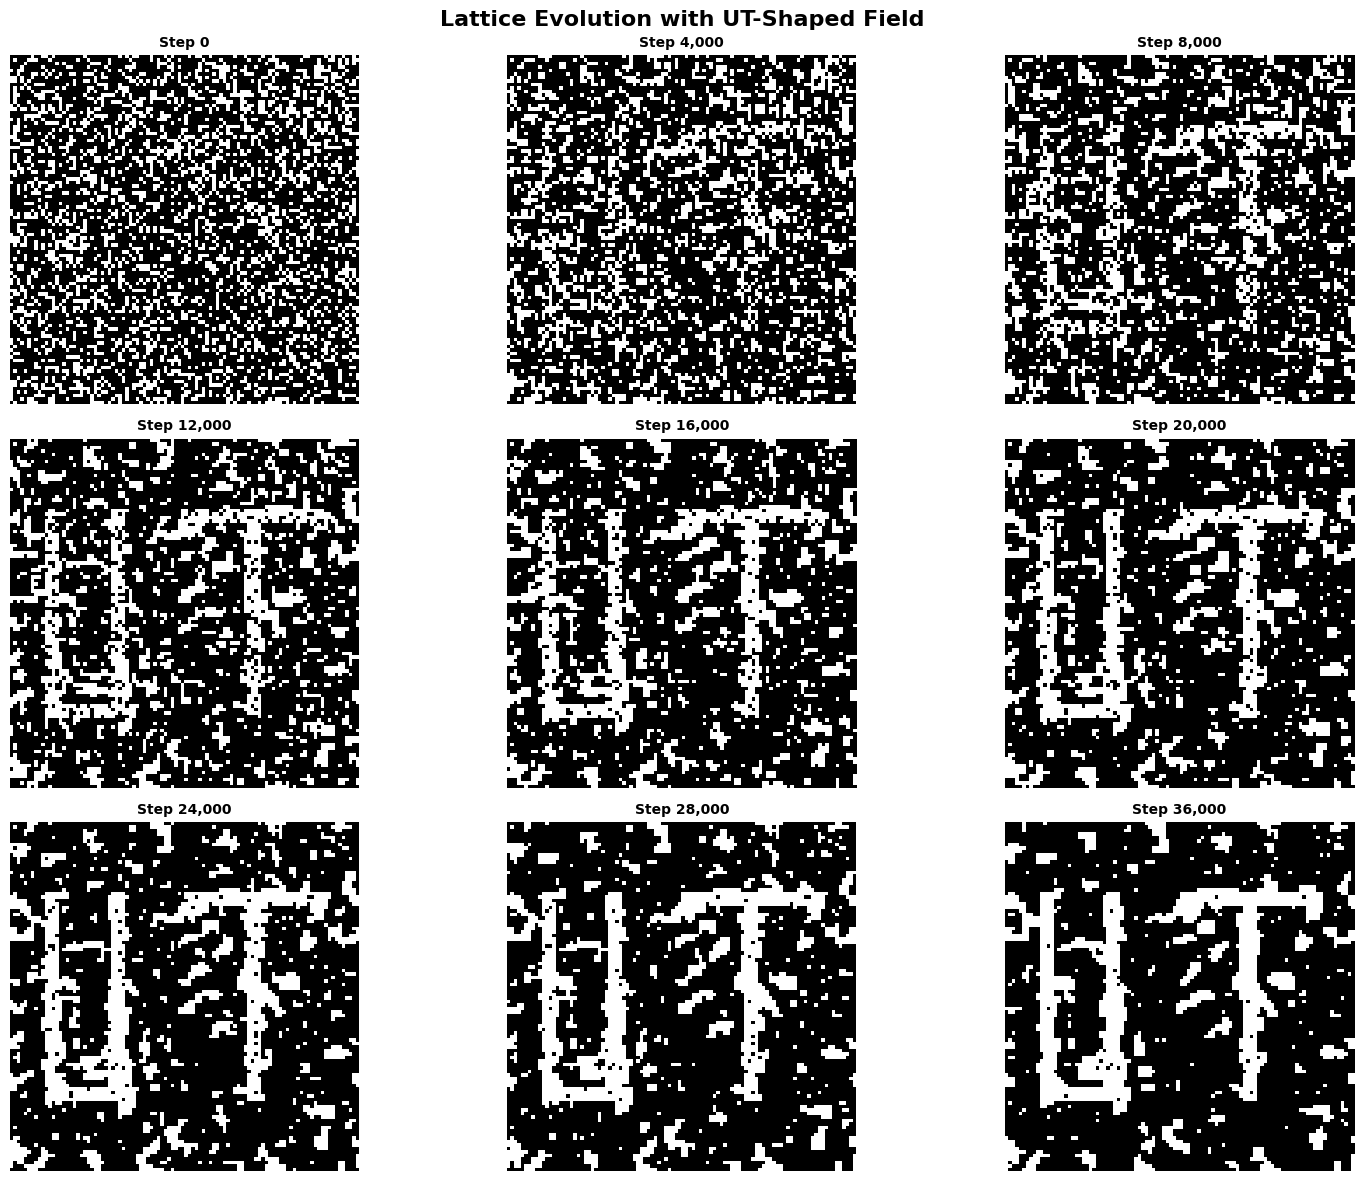

In [ ]:
#POSITION DEPENDENT UT-SHAPED FIELD


N_field = 100
ut_field = UTField(H0=5)

print(f"Lattice size: {N_field} × {N_field}")
print(f"Field strength: H0 = 5")
print()

vis.plot_field(ut_field.position_dependent(N_field), "UT-Shaped External Field")

model_ut = IsingModel(N=N_field, temperature=1.0, external_field=ut_field)
model_ut.initialize_lattice(threshold=0.7)

spins, energies, final, snaps, times = model_ut.metropolis_with_snapshots(
    timesteps=40000, snapshot_interval=4000
)

print(f"Captured {len(snaps)} snapshots")
vis.plot_snapshots(snaps, times, "Lattice Evolution with UT-Shaped Field")



Simulating with oscillating field H(t) = 10*cos(π*0.00005*t)...
Lattice size: 50 × 50
Time steps: 100,000



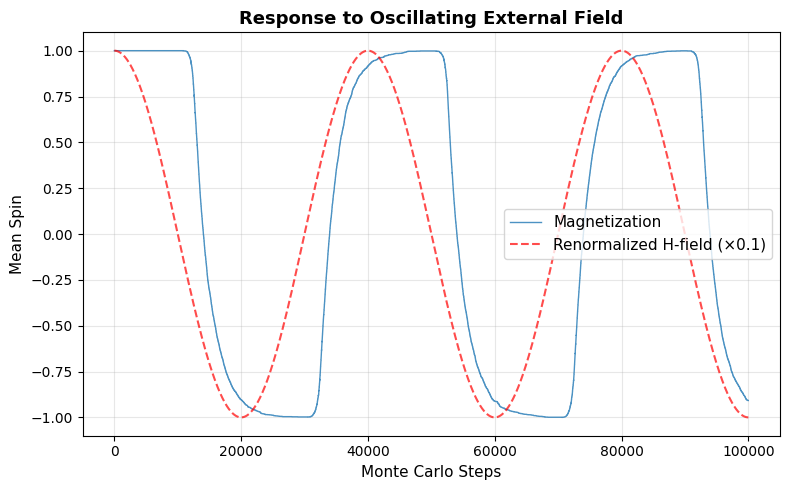

In [21]:
#TIME-DEPENDENT OSCILLATING FIELD
N_osc = 50
osc_field = OscillatingField(amplitude=10.0, omega=0.00005)
timesteps_osc = 100000

print(f"Simulating with oscillating field H(t) = 10*cos(π*0.00005*t)...")
print(f"Lattice size: {N_osc} × {N_osc}")
print(f"Time steps: {timesteps_osc:,}")
print()

model_osc = IsingModel(N=N_osc, temperature=1.0, external_field=osc_field)
model_osc.initialize_lattice(threshold=0.0)  # Start all spin down

spins_osc, energies_osc, final_osc = model_osc.metropolis_with_field(timesteps_osc)

# Plot magnetization vs field
t = np.arange(0, timesteps_osc - 1, 1)
field_values = osc_field.time_dependent(t)

plt.figure(figsize=(8, 5))
plt.plot(t, spins_osc / N_osc**2, linewidth=1, label='Magnetization', alpha=0.8)
plt.plot(t, 0.1 * field_values, '--', linewidth=1.5,
          label='Renormalized H-field (×0.1)', alpha=0.7, color='red')
plt.xlabel('Monte Carlo Steps', fontsize=11)
plt.ylabel('Mean Spin', fontsize=11)
plt.title('Response to Oscillating External Field', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Simulating triangular lattice at T = 3.0
  Final magnetization: 0.934

Simulating triangular lattice at T = 3.4
  Final magnetization: 0.850

Simulating triangular lattice at T = 3.8
  Final magnetization: 0.086

Simulating triangular lattice at T = 4.2
  Final magnetization: 0.038


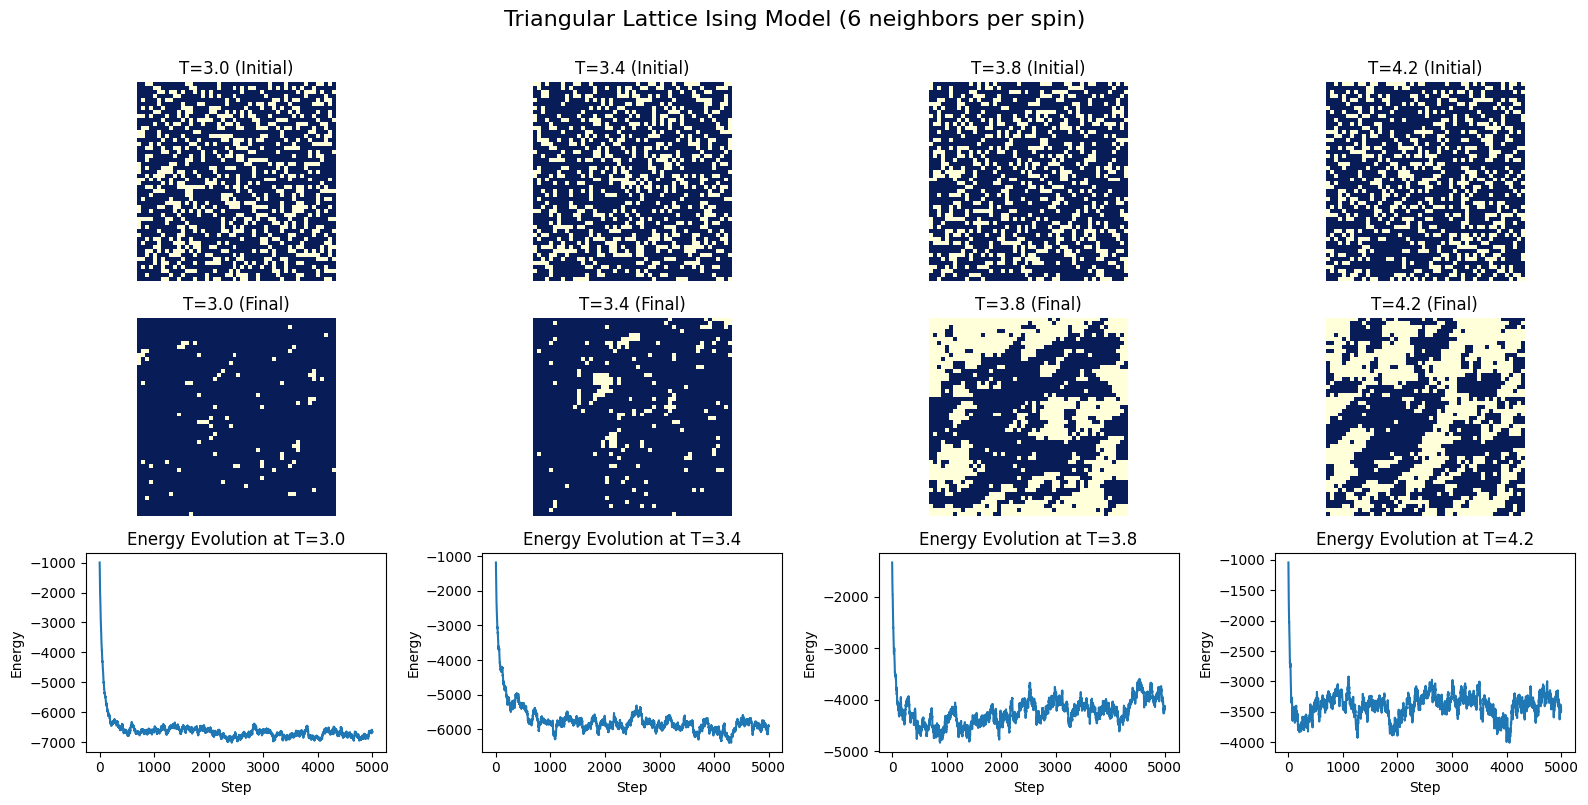

In [22]:
#TRIANGULAR LATTICE

class IsingModelTriangular:
    def __init__(self, size: int, J: float = 1.0):
        self.size = size
        self.J = J
        self.state = None

    def initialize_random(self, spin_up_fraction=0.7):
        self.state = np.random.choice([-1, 1], size=(self.size, self.size),
                                      p=[1-spin_up_fraction, spin_up_fraction])
        return self.state

    def energy(self, state=None):
        '''Calculates total energy by summing over 3 bond directions
        (to avoid double-counting each bond).
        Triangular lattice has bonds: right, down, and upper-right diagonal'''
        if state is None:
            state = self.state

        energy = 0
        energy -= self.J * np.sum(state * np.roll(state, -1, axis=1))
        energy -= self.J * np.sum(state * np.roll(state, -1, axis=0))
        energy -= self.J * np.sum(state * np.roll(np.roll(state, -1, axis=1), 1, axis=0))
        #Avoid double counting, but in the metropolis step, we consider all 6 neighbors
        return energy

    def local_energy_change(self, i, j):
        spin = self.state[i, j]

        neighbors_sum = (
            self.state[(i+1) % self.size, j] +           # down
            self.state[(i-1) % self.size, j] +           # up
            self.state[i, (j+1) % self.size] +           # right
            self.state[i, (j-1) % self.size] +           # left
            self.state[(i-1) % self.size, (j+1) % self.size] +  # upper-right
            self.state[(i+1) % self.size, (j-1) % self.size]    # lower-left
        )

        return 2 * self.J * spin * neighbors_sum

    def magnetization(self, state=None):
        '''Returns the magnetization = the average spin value'''
        if state is None:
            state = self.state
        return np.mean(state)

    def simulate(self, temperature, n_steps):  # Metropolis algorithm
        states = [self.state.copy()]
        energies = [self.energy()]
        magnetizations = [self.magnetization()]

        for step in range(n_steps):
            # Pick random spin
            i = np.random.randint(0, self.size)
            j = np.random.randint(0, self.size)

            # Calculate energy change using all 6 neighbors
            delta_E = self.local_energy_change(i, j)

            # Metropolis criterion
            if delta_E < 0 or np.random.rand() < np.exp(-delta_E / temperature):
                self.state[i, j] *= -1  # Flip the spin

            if (step + 1) % 100 == 0:
                states.append(self.state.copy())
                energies.append(self.energy())
                magnetizations.append(self.magnetization())

        return states, energies, magnetizations


# VISUALIZE INITIAL AND FINAL STATES FOR MULTIPLE TEMPERATURES
temperatures = [3.0, 3.4, 3.8, 4.2]

fig, axes = plt.subplots(3, 4, figsize=(16, 8))
fig.suptitle('Triangular Lattice Ising Model (6 neighbors per spin)', fontsize=16, y=1.00)

for idx, T in enumerate(temperatures):
    print(f"\nSimulating triangular lattice at T = {T}")

    model = IsingModelTriangular(size=50, J=1.0)

    initial = model.initialize_random(spin_up_fraction=0.7)

    states, energies, _ = model.simulate(temperature=T, n_steps=500000)

    # Plot initial and final states
    axes[0, idx].imshow(states[0], cmap='YlGnBu', vmin=-1, vmax=1)
    axes[0, idx].set_title(f'T={T:.1f} (Initial)')
    axes[0, idx].axis('off')

    axes[1, idx].imshow(states[-1], cmap='YlGnBu', vmin=-1, vmax=1)
    axes[1, idx].set_title(f'T={T:.1f} (Final)')
    axes[1, idx].axis('off')

    axes[2, idx].plot(energies)
    axes[2, idx].set_xlabel('Step')
    axes[2, idx].set_ylabel('Energy')
    axes[2, idx].set_title(f'Energy Evolution at T={T}')

    final_mag = model.magnetization(states[-1])
    print(f"  Final magnetization: {abs(final_mag):.3f}")

plt.tight_layout()
plt.show()


Simulating at T = 2.9
  Final magnetization: 0.952

Simulating at T = 2.92
  Final magnetization: 0.916

Simulating at T = 2.94
  Final magnetization: 0.900

Simulating at T = 2.96
  Final magnetization: 0.945

Simulating at T = 2.98
  Final magnetization: 0.935

Simulating at T = 3.0
  Final magnetization: 0.930

Simulating at T = 3.02
  Final magnetization: 0.907

Simulating at T = 3.04
  Final magnetization: 0.938

Simulating at T = 3.06
  Final magnetization: 0.920

Simulating at T = 3.08
  Final magnetization: 0.922

Simulating at T = 3.1
  Final magnetization: 0.912

Simulating at T = 3.12
  Final magnetization: 0.907

Simulating at T = 3.14
  Final magnetization: 0.933

Simulating at T = 3.16
  Final magnetization: 0.905

Simulating at T = 3.18
  Final magnetization: 0.926

Simulating at T = 3.2
  Final magnetization: 0.888

Simulating at T = 3.22
  Final magnetization: 0.937

Simulating at T = 3.24
  Final magnetization: 0.848

Simulating at T = 3.2600000000000002
  Final magn

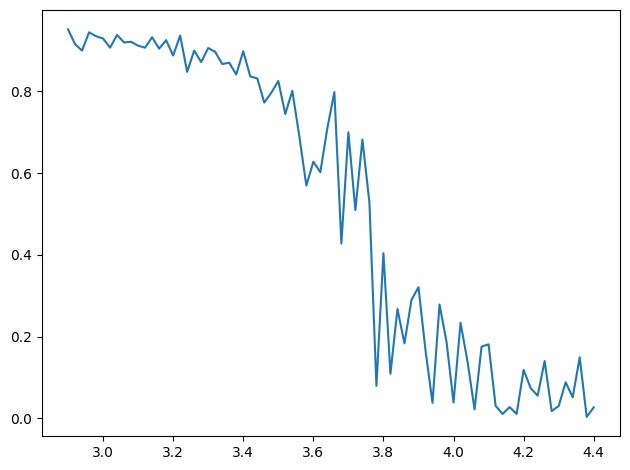

In [23]:
#plot magnetization

temperatures = np.arange(2.9, 4.4, 0.02)
tri_mag = []

for idx, T in enumerate(temperatures):
    print(f"\nSimulating at T = {T}")

    model = IsingModelTriangular(size=50, J=1.0)

    initial = model.initialize_random(spin_up_fraction=0.7)

    states, energies, _ = model.simulate(temperature=T, n_steps=500000)

    final_mag = model.magnetization(states[-1])

    print(f"  Final magnetization: {abs(final_mag):.3f}")
    tri_mag.append(abs(final_mag))
plt.plot(temperatures, tri_mag)
plt.tight_layout()
plt.show()


Simulating hexagonal lattice at T = 1.5
  Final magnetization: 0.648

Simulating hexagonal lattice at T = 2.0
  Final magnetization: 0.027

Simulating hexagonal lattice at T = 2.5
  Final magnetization: 0.008

Simulating hexagonal lattice at T = 3.0
  Final magnetization: 0.001


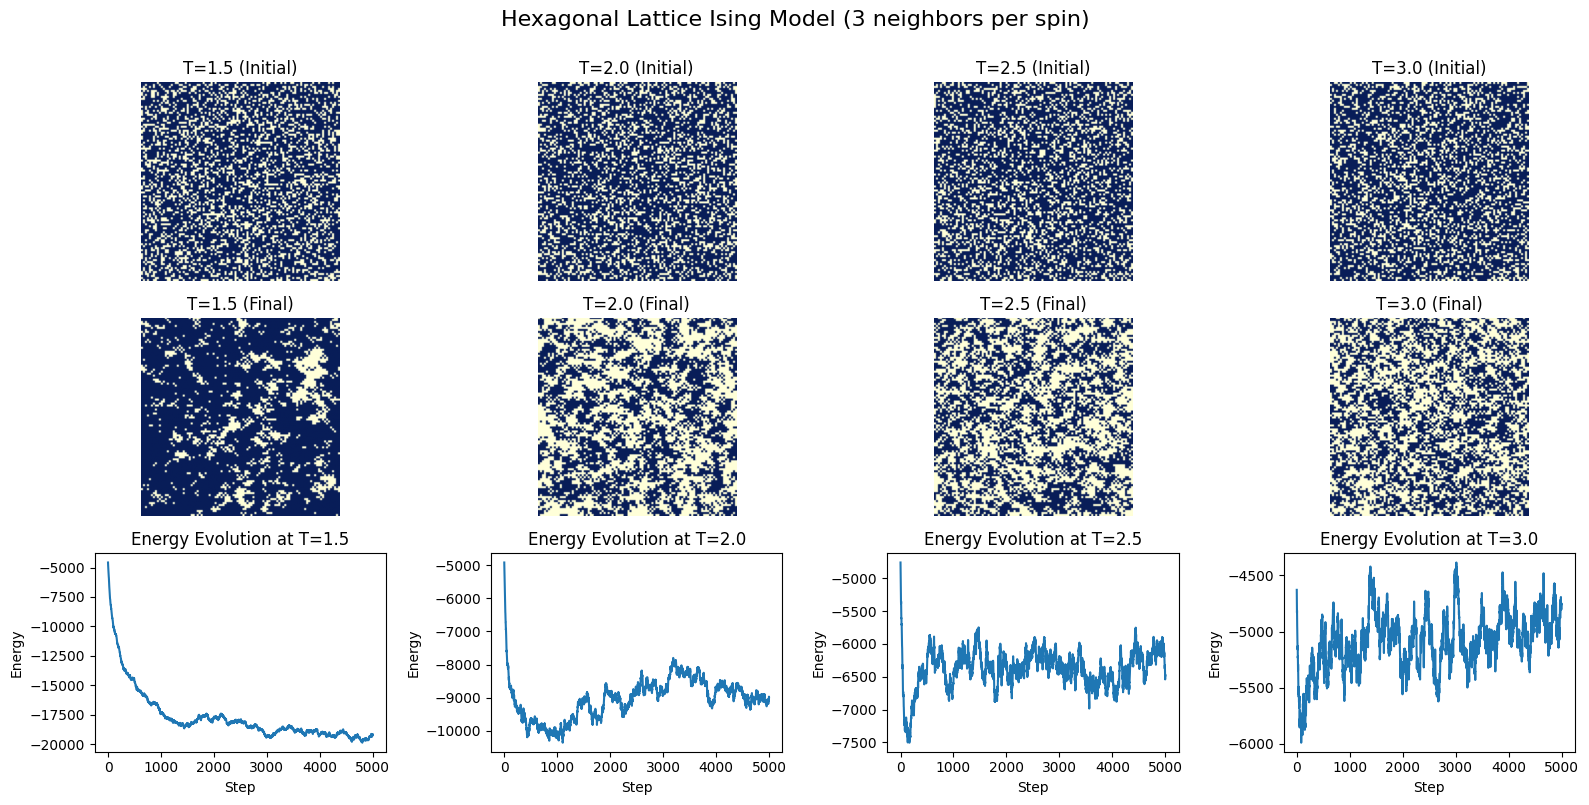

In [24]:
# HEXAGONAL LATTICE

class IsingModelHexagonal:
    def __init__(self, size: int, J: float = 1.0):
        self.size = size
        self.J = J
        self.state = None

    def initialize_random(self, spin_up_fraction=0.7):
        self.state = np.random.choice([-1, 1], size=(self.size, self.size),
                                      p=[1-spin_up_fraction, spin_up_fraction])
        return self.state

    def energy(self, state=None):
        '''Calculates total energy by summing over 3 bond directions
        (to avoid double-counting each bond).
        Hexagonal lattice has bonds: right, down-left, and down-right'''
        if state is None:
            state = self.state

        energy = 0
        # Right neighbor
        energy -= self.J * np.sum(state * np.roll(state, -1, axis=1))
        # Down-left neighbor (down and left)
        energy -= self.J * np.sum(state * np.roll(np.roll(state, -1, axis=0), 1, axis=1))
        # Down-right neighbor (down and right)
        energy -= self.J * np.sum(state * np.roll(np.roll(state, -1, axis=0), -1, axis=1))

        return energy

    def local_energy_change(self, i, j):
        '''Calculate energy change if spin at (i,j) is flipped.
        Hexagonal lattice: each spin has 3 neighbors'''
        spin = self.state[i, j]

        neighbors_sum = (
            self.state[i, (j+1) % self.size] +                          # right
            self.state[(i+1) % self.size, (j-1) % self.size] +          # down-left
            self.state[(i+1) % self.size, (j+1) % self.size]            # down-right
        )

        return 2 * self.J * spin * neighbors_sum

    def magnetization(self, state=None):
        '''Returns the magnetization = the average spin value'''
        if state is None:
            state = self.state
        return np.mean(state)

    def simulate(self, temperature, n_steps):
        '''Uses the metropolis algorithm to keep or reject random spin flips.
        Returns states, energies, and magnetizations.'''
        states = [self.state.copy()]
        energies = [self.energy()]
        magnetizations = [self.magnetization()]

        for step in range(n_steps):
            # Pick random spin
            i = np.random.randint(0, self.size)
            j = np.random.randint(0, self.size)

            # Calculate energy change using 3 neighbors
            delta_E = self.local_energy_change(i, j)

            # Metropolis criterion
            if delta_E < 0 or np.random.rand() < np.exp(-delta_E / temperature):
                self.state[i, j] *= -1  # Flip the spin

            if (step + 1) % 100 == 0:
                states.append(self.state.copy())
                energies.append(self.energy())
                magnetizations.append(self.magnetization())

        return states, energies, magnetizations


# VISUALIZE INITIAL AND FINAL STATES FOR MULTIPLE TEMPERATURES
temperatures = [1.5, 2.0, 2.5, 3.0]

fig, axes = plt.subplots(3, 4, figsize=(16, 8))
fig.suptitle('Hexagonal Lattice Ising Model (3 neighbors per spin)', fontsize=16, y=1.00)

for idx, T in enumerate(temperatures):
    print(f"\nSimulating hexagonal lattice at T = {T}")

    model = IsingModelHexagonal(size=100, J=1.0)

    initial = model.initialize_random(spin_up_fraction=0.7)

    states, energies, _ = model.simulate(temperature=T, n_steps=500000)

    # Plot initial and final states
    axes[0, idx].imshow(states[0], cmap='YlGnBu', vmin=-1, vmax=1)
    axes[0, idx].set_title(f'T={T:.1f} (Initial)')
    axes[0, idx].axis('off')

    axes[1, idx].imshow(states[-1], cmap='YlGnBu', vmin=-1, vmax=1)
    axes[1, idx].set_title(f'T={T:.1f} (Final)')
    axes[1, idx].axis('off')

    axes[2, idx].plot(energies)
    axes[2, idx].set_xlabel('Step')
    axes[2, idx].set_ylabel('Energy')
    axes[2, idx].set_title(f'Energy Evolution at T={T}')

    final_mag = model.magnetization(states[-1])
    print(f"  Final magnetization: {abs(final_mag):.3f}")

plt.tight_layout()
plt.show()


Simulating at T = 0.8
  Final magnetization: 0.998

Simulating at T = 0.8200000000000001
  Final magnetization: 0.998

Simulating at T = 0.8400000000000001
  Final magnetization: 0.997

Simulating at T = 0.8600000000000001
  Final magnetization: 0.998

Simulating at T = 0.8800000000000001
  Final magnetization: 0.998

Simulating at T = 0.9000000000000001
  Final magnetization: 0.998

Simulating at T = 0.9200000000000002
  Final magnetization: 0.997

Simulating at T = 0.9400000000000002
  Final magnetization: 0.994

Simulating at T = 0.9600000000000002
  Final magnetization: 0.998

Simulating at T = 0.9800000000000002
  Final magnetization: 0.990

Simulating at T = 1.0000000000000002
  Final magnetization: 0.987

Simulating at T = 1.0200000000000002
  Final magnetization: 0.990

Simulating at T = 1.0400000000000003
  Final magnetization: 0.989

Simulating at T = 1.0600000000000003
  Final magnetization: 0.987

Simulating at T = 1.0800000000000003
  Final magnetization: 0.986

Simulatin

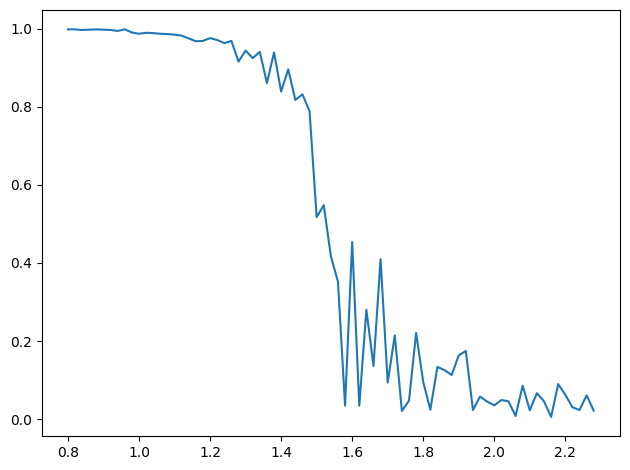

In [25]:
#plot magnetization

temperatures = np.arange(0.8, 2.3, 0.02)
hex_mag = []

for idx, T in enumerate(temperatures):
    print(f"\nSimulating at T = {T}")

    model = IsingModelHexagonal(size=50, J=1.0)

    initial = model.initialize_random(spin_up_fraction=0.7)

    states, energies, _ = model.simulate(temperature=T, n_steps=500000)

    final_mag = model.magnetization(states[-1])

    print(f"  Final magnetization: {abs(final_mag):.3f}")
    hex_mag.append(abs(final_mag))
plt.plot(temperatures, hex_mag)
plt.tight_layout()
plt.show()

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
#  Unified Ising model with position-dependent and uniform field
# ============================================================

class IsingModel:
    def __init__(self, size: int, J: float = 1.0, field: np.ndarray | None = None):
        """
        size   : linear lattice size (size x size)
        J      : nearest-neighbor coupling
        field  : position-dependent external field H[i,j] (same shape as lattice),
                 in energy units. If None, no position-dependent field.
        """
        self.size = size
        self.J = J
        self.state = None
        self.field = field  # H_ij
        self.h_history = []  # will store uniform/time-dependent field if used

    # ---------- basic setup ----------

    def set_field(self, field: np.ndarray):
        """Attach / change the position-dependent external field."""
        assert field.shape == (self.size, self.size), "field must match lattice size"
        self.field = field

    def initialize_random(self, spin_up_fraction=0.5):
        """
        Create a size x size lattice of spins in {-1, +1},
        with given fraction of +1 spins.
        """
        self.state = np.random.choice(
            [-1, 1],
            size=(self.size, self.size),
            p=[1 - spin_up_fraction, spin_up_fraction],
        )
        return self.state

    # ---------- energies ----------

    def energy(self, state=None, h: float = 0.0):
        """
        Total energy:
        E = -J Σ_<ij> s_i s_j - Σ_i H_i s_i - h Σ_i s_i

        where:
          - H_i is the position-dependent field (self.field[i,j]) if provided,
          - h is an optional uniform field (possibly time-dependent).
        """
        if state is None:
            state = self.state

        # nearest-neighbor interactions with periodic BCs
        E = 0.0
        # vertical bonds
        E -= self.J * np.sum(state * np.roll(state, -1, axis=0))
        # horizontal bonds
        E -= self.J * np.sum(state * np.roll(state, -1, axis=1))

        # position-dependent field
        if self.field is not None:
            E -= np.sum(self.field * state)

        # uniform field
        if h != 0.0:
            E -= h * np.sum(state)

        return E

    def local_energy_change(self, i, j, h: float = 0.0):
        """
        ΔE for flipping spin at (i,j) with position-dependent + uniform field:

        ΔE = 2 s_ij ( J Σ_neighbors s_neighbor + H_ij + h )
        """
        s = self.state[i, j]

        # sum of 4 nearest neighbors (periodic BC)
        neighbors_sum = (
            self.state[(i + 1) % self.size, j] +
            self.state[(i - 1) % self.size, j] +
            self.state[i, (j + 1) % self.size] +
            self.state[i, (j - 1) % self.size]
        )

        H_ij = 0.0 if self.field is None else self.field[i, j]

        return 2.0 * s * (self.J * neighbors_sum + H_ij + h)

    # ---------- observables ----------

    def magnetization(self, state=None):
        """Average spin per site."""
        if state is None:
            state = self.state
        return np.mean(state)

    # ---------- dynamics ----------

    def simulate(self, temperature, n_steps, h_func=None, sample_every=100):
        """
        Metropolis simulation with optional time-dependent uniform field h_func(step).

        Records state, energy, and magnetization every `sample_every` MC steps.
        Also stores the uniform h(t) samples in self.h_history.

        Returns
        -------
        states : list of 2D arrays
        energies : list of floats
        magnetizations : list of floats
        """
        # initial sample at "step 0"
        states = [self.state.copy()]
        h0 = h_func(0) if h_func is not None else 0.0
        energies = [self.energy(h=h0)]
        magnetizations = [self.magnetization()]
        h_history = [h0]

        for step in range(n_steps):
            # uniform field at this MC step
            h = h_func(step) if h_func is not None else 0.0

            # pick random spin
            i = np.random.randint(0, self.size)
            j = np.random.randint(0, self.size)

            # Metropolis criterion
            dE = self.local_energy_change(i, j, h=h)
            if dE < 0 or np.random.rand() < np.exp(-dE / temperature):
                self.state[i, j] *= -1

            # sample every `sample_every` steps
            if (step + 1) % sample_every == 0:
                states.append(self.state.copy())
                energies.append(self.energy(h=h))
                magnetizations.append(self.magnetization())
                h_history.append(h)

        self.h_history = h_history
        return states, energies, magnetizations

    def run(self, T: float, n_steps: int, sample_interval: int = 10_000):
        """
        Convenience wrapper (no uniform field) to mimic your UT code:

        Returns
        -------
        snapshots : list of 2D spin arrays
        times     : list of MC step indices for each snapshot
        """
        states, _, _ = self.simulate(
            temperature=T,
            n_steps=n_steps,
            h_func=None,
            sample_every=sample_interval,
        )

        # times corresponding to the initial state and each sample
        times = [0] + [sample_interval * k for k in range(1, len(states))]
        return states, times


# ============================================================
#  Theoretical magnetization (exact 2D Ising)
# ============================================================

def theoretical_magnetization(T, J=1.0, k=1.0):
    """
    Exact 2D Ising magnetization (Onsager/Yang result) for T < Tc,
    and 0 for T > Tc.
    """
    Tc = 2.269185 * J / k
    if T > Tc:
        return 0.0
    else:
        z = np.exp(-2 * J / (k * T))
        return (1 + z**2)**0.25 * (1 - 6 * z**2 + z**4)**0.125


# ============================================================
#  Monte Carlo magnetization vs temperature (average over runs)
# ============================================================

def mag_vs_temperature(
    size,
    temps,
    J=1.0,
    n_steps=200000,
    n_runs=5,
    spin_up_fraction=0.7,
):
    """
    For each temperature T in temps:
      - run n_runs independent simulations
      - use magnetization time series from simulate()
      - average |m| over the remaining samples
    Returns an array of smoothed magnetizations vs T.
    """
    mags_T = []

    for T in temps:
        print(f"\nSimulating (mag vs T) at T = {T:.3f}")
        run_mags = []

        for run in range(n_runs):
            model = IsingModel(size=size, J=J)
            model.initialize_random(spin_up_fraction=spin_up_fraction)

            # record every 100 steps (same as your old code)
            _, _, mags = model.simulate(
                temperature=T,
                n_steps=n_steps,
                h_func=None,
                sample_every=1000,
            )
            temp = np.abs(mags[-10:])# take the average for the last few mag
            run_mags.append(np.mean(temp))

        run_ave = np.mean(run_mags)
        mags_T.append(run_ave)

    return np.array(mags_T)


# ============================================================
#  UT-shaped position-dependent field H_ij
# ============================================================

def create_UT_field(size: int, H0: float = 2.0) -> np.ndarray:
    """
    Create a size x size field matrix H, where H = H0 in the regions
    shaped like the letters "U" and "T", and 0 elsewhere.
    """
    H = np.zeros((size, size), dtype=float)

    # geometry parameters in pixels
    t = max(1, size // 25)     # stroke thickness
    top = size // 5
    bottom = 4 * size // 5

    # ----- U letter -----
    u_left = size // 10
    u_right = size // 3

    # two vertical bars
    H[top:bottom, u_left:u_left + t] = H0
    H[top:bottom, u_right - t:u_right] = H0

    # bottom bar
    H[bottom - t:bottom, u_left:u_right] = H0

    # ----- T letter -----
    t_left = size // 2
    t_right = 9 * size // 10

    # top horizontal bar
    H[top:top + t, t_left:t_right] = H0

    # vertical stem in the middle
    t_center = (t_left + t_right) // 2
    H[top:bottom, t_center - t // 2 : t_center + (t + 1) // 2] = H0

    return H


Simulating full config at T = 0.5
  Final magnetization: 1.000

Simulating full config at T = 2.0
  Final magnetization: 0.888

Simulating full config at T = 2.5
  Final magnetization: 0.147

Simulating full config at T = 4.0
  Final magnetization: 0.074


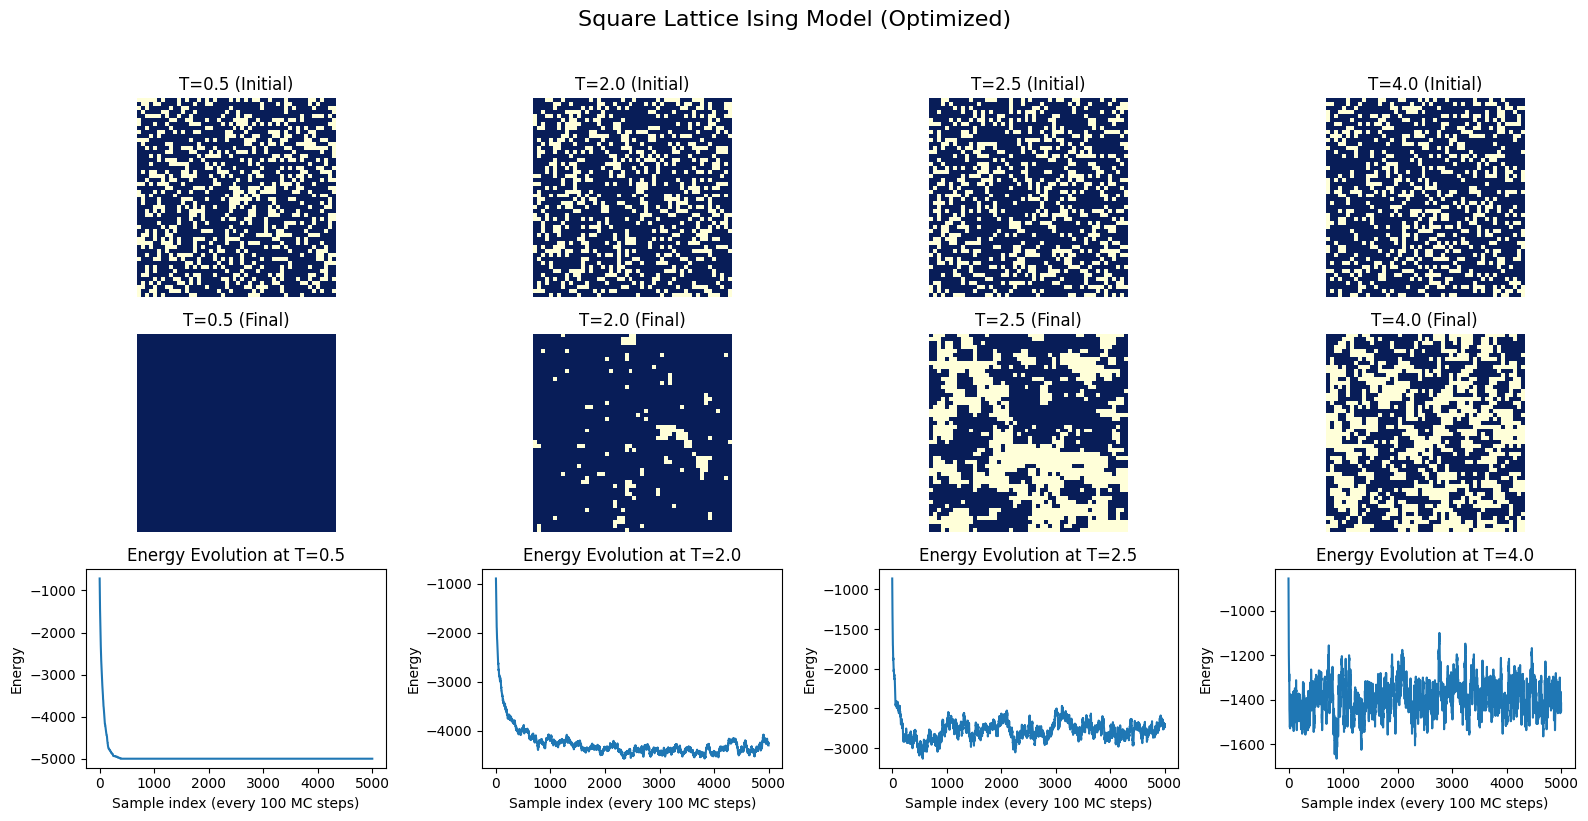

In [27]:
# ================================================================
# 1) Visualize initial and final states + energy evolution
# ================================================================

temperatures = [0.5, 2.0, 2.5, 4.0]

fig, axes = plt.subplots(3, len(temperatures), figsize=(16, 8))
fig.suptitle('Square Lattice Ising Model (Optimized)', fontsize=16, y=1.02)

for idx, T in enumerate(temperatures):
    print(f"\nSimulating full config at T = {T}")

    model = IsingModel(size=50, J=1.0)
    initial = model.initialize_random(spin_up_fraction=0.7)

    # No external field in this part
    states, energies, mags = model.simulate(temperature=T, n_steps=500_000)

    # Plot initial and final states
    axes[0, idx].imshow(states[0], cmap='YlGnBu', vmin=-1, vmax=1)
    axes[0, idx].set_title(f'T={T:.1f} (Initial)')
    axes[0, idx].axis('off')

    axes[1, idx].imshow(states[-1], cmap='YlGnBu', vmin=-1, vmax=1)
    axes[1, idx].set_title(f'T={T:.1f} (Final)')
    axes[1, idx].axis('off')

    axes[2, idx].plot(energies)
    axes[2, idx].set_xlabel('Sample index (every 100 MC steps)')
    axes[2, idx].set_ylabel('Energy')
    axes[2, idx].set_title(f'Energy Evolution at T={T}')

    final_mag = model.magnetization(states[-1])
    print(f"  Final magnetization: {abs(final_mag):.3f}")

plt.tight_layout()
plt.show()


Simulating (mag vs T) at T = 2.000

Simulating (mag vs T) at T = 2.100

Simulating (mag vs T) at T = 2.200

Simulating (mag vs T) at T = 2.300

Simulating (mag vs T) at T = 2.400

Simulating (mag vs T) at T = 2.500

Simulating (mag vs T) at T = 2.600


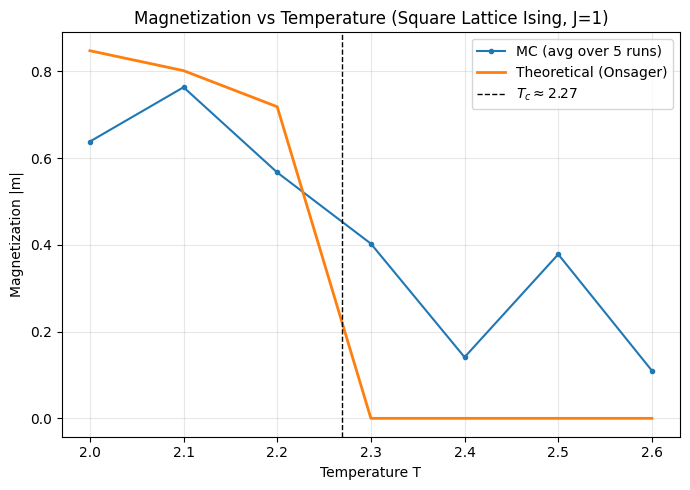

In [28]:


# ================================================================
# 2) Magnetization vs temperature (Monte Carlo average over 5 runs)
#    + Theoretical magnetization curve overlay
# ================================================================

temps = np.arange(2.0, 2.6, 0.1)

square_mag = mag_vs_temperature(
    size=50,
    temps=temps,
    J=1.0,
    n_steps=200000,
    n_runs=1,
    spin_up_fraction=0.4,
)

# Theoretical magnetization (same temperature grid for easy comparison)
theory_mag = np.array([theoretical_magnetization(T, J=1.0, k=1.0) for T in temps])

plt.figure(figsize=(7, 5))
plt.plot(temps, square_mag, 'o-', markersize=3, label='MC (avg over 5 runs)')
plt.plot(temps, theory_mag, '-', linewidth=2, label='Theoretical (Onsager)')
plt.axvline(2.269185, color='k', linestyle='--', linewidth=1, label=r'$T_c \approx 2.27$')

plt.xlabel('Temperature T')
plt.ylabel('Magnetization |m|')
plt.title('Magnetization vs Temperature (Square Lattice Ising, J=1)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




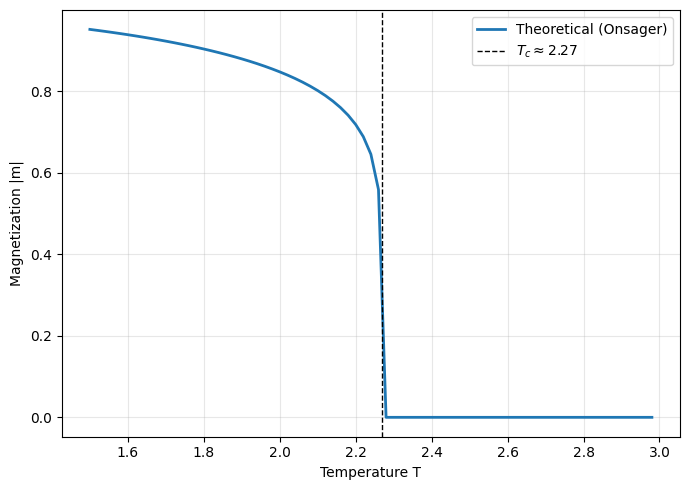

In [29]:
# ================================================================
# 2.5) Theoretical Magnetization vs temperature
# ================================================================

temps = np.arange(1.5, 3.0, 0.02)


# Theoretical magnetization (same temperature grid for easy comparison)
theory_mag = np.array([theoretical_magnetization(T, J=1.0, k=1.0) for T in temps])

plt.figure(figsize=(7, 5))
plt.plot(temps, theory_mag, '-', linewidth=2, label='Theoretical (Onsager)')
plt.axvline(2.269185, color='k', linestyle='--', linewidth=1, label=r'$T_c \approx 2.27$')

plt.xlabel('Temperature T')
plt.ylabel('Magnetization |m|')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

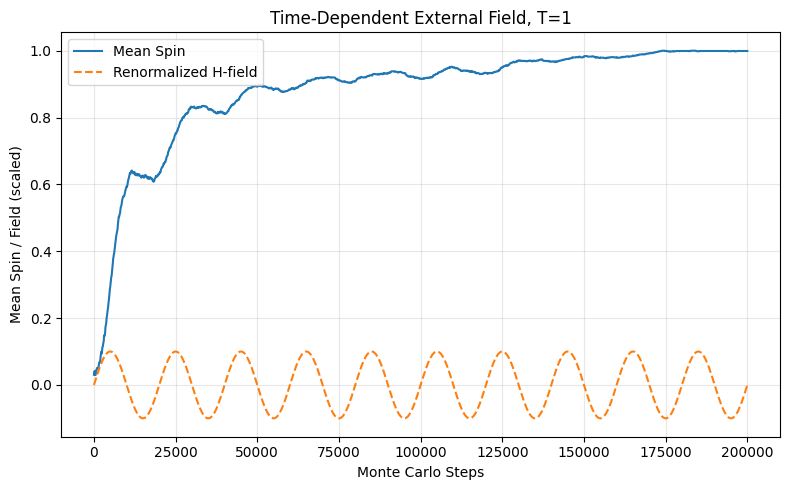

In [30]:
# ================================================================
# 3) External field plot: mean spin vs time and field vs time
# ================================================================

def time_dependent_field(step, H0=0.2, period=20_000):
    """
    Simple sinusoidal time-dependent external field H(t).
    step: Monte Carlo step index
    H0:   field amplitude
    period: period in MC steps
    """
    return H0 * np.sin(2 * np.pi * step / period)


N = 50
T_ext = 1          # temperature for the external-field run
n_steps_ext = 200_000

model_ext = IsingModel(size=N, J=1.0)
model_ext.initialize_random(spin_up_fraction=0.5)

# Run with time-dependent field; h_func is sampled at every MC step
_, energies_ext, mags_ext = model_ext.simulate(
    temperature=T_ext,
    n_steps=n_steps_ext,
    h_func=lambda step: time_dependent_field(step, H0=0.5, period=20_000)
)

mags_ext = np.array(mags_ext)          # magnetization samples (every 100 MC steps)
h_hist = np.array(model_ext.h_history) # external field at the same sampling times

# "Time" axis in units of 100 MC steps, similar to how we recorded samples
t_samples = 100 * np.arange(len(mags_ext))

plt.figure(figsize=(8, 5))
plt.plot(t_samples, mags_ext, label='Mean Spin')
# Rescale field so it fits nicely on the same plot (like your 0.1 * H(t))
plt.plot(t_samples, 0.2 * h_hist, '--', label='Renormalized H-field')
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Mean Spin / Field (scaled)')
plt.title(f'Time-Dependent External Field, T={T_ext}')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [41]:

# ============================================================
#  Run the Ising model with UT-shaped field and visualize
# ============================================================

N = 200            # lattice size
J = 1.0
T = 1           # temperature (in J/k_B units)
n_steps = 100000  # total MC steps
sample_interval = 20000  # how often to record a snapshot

# Create UT-shaped position-dependent field
H_UT = create_UT_field(N, H0=2.0)

# Visualize the field itself
plt.figure(figsize=(2.5, 2.5))
plt.title("UT-shaped external field $H_{ij}$")
plt.imshow(H_UT,cmap="gray", vmin=-1, vmax=1)
plt.axis("off")
plt.tight_layout()
plt.show()

# Initialize Ising model with this field
model = IsingModel(size=N, J=J, field=H_UT)
model.initialize_random(spin_up_fraction=0.5)

# Run dynamics and record snapshots
snapshots, times = model.run(T=T, n_steps=n_steps, sample_interval=sample_interval)

# Plot evolution: initial + a few later times
n_snap = len(snapshots)
plt.figure(figsize=(3 * n_snap, 3))

for k, (state, t_step) in enumerate(zip(snapshots, times)):
    ax = plt.subplot(1, n_snap, k + 1)
    ax.imshow(state, cmap="gray", vmin=-1, vmax=1)
    ax.set_title(f"t = {t_step}")
    ax.axis("off")

plt.suptitle(f"Ising spins under UT-shaped position-dependent field (T = {T})",
              y=1.02)
plt.tight_layout()
plt.show()


from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

def animate_ut_field(N=100, H0=2.0, J=1.0, T=1.0, n_steps=500000, sample_interval=20000, cmap='gray', interval=500):
    """
    Create a FuncAnimation of Ising lattice evolution under the UT-shaped, position-dependent field.
    - Keep sample_interval large enough so number of frames = 1 + n_steps//sample_interval is reasonable.
    """
    H_UT = create_UT_field(N, H0=H0)
    model = IsingModel(size=N, J=J, field=H_UT)
    model.initialize_random(spin_up_fraction=0.5)

    # run returns sampled states and their times
    snapshots, times = model.run(T=T, n_steps=n_steps, sample_interval=sample_interval)

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(snapshots[0], cmap=cmap, vmin=-1, vmax=1, interpolation='nearest')
    ax.axis('off')
    title = ax.set_title(f"t = {times[0]}  T={T}, H0={H0}")

    def update(frame):
        im.set_data(snapshots[frame])
        title.set_text(f"t = {times[frame]}  T={T}, H0={H0}")
        return (im, title)

    anim = FuncAnimation(fig, update, frames=len(snapshots), interval=interval, blit=True, repeat=True)
    plt.close(fig)  # prevent static display of final frame in notebook

    # Inline display in notebook; also returns the animation object for saving
    display(HTML(anim.to_jshtml()))
    return anim

# Example usage (adjust N, n_steps and sample_interval to get ~5–20 frames):
anim = animate_ut_field(N=250, H0=2.0, J=1.0, T=1.0, n_steps=500000, sample_interval=10000, interval=60)

from matplotlib.animation import PillowWriter
out_path = "C:\Users\sl57562\Documents\Misc Code\NN_Daydreamer\UT.gif"
anim.save(out_path, writer=PillowWriter(fps=10))
print(f"Saved animation to {out_path}")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2545094193.py, line 81)